### Malaria cell prediction

This projects tries to predict if a cell is malaria parasitized or uninfected.
The prepared dataset is from [Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria).

The task is to build a neural network that predicts a cell image with a high recall.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing import image
from tensorflow.python.keras.callbacks import EarlyStopping
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import shap

Data is saved locally but it is the orginial folder structure from Kaggle.

In [2]:
parasitized_path = "D:\\KI_Dataset\\Malaria_images\\cell_images\\Parasitized"
uninfected_path = "D:\\KI_Dataset\\Malaria_images\\cell_images\\Uninfected"

In [3]:
def collect_images(path,target):
    images_list = []
    target_list = []
    target = target
    for r, d, f in os.walk(path):
        for file in f:
            if ('.png' in file):
                images_list.append(os.path.join(r, file))
                target_list.append(target)

    features =np.transpose([np.array(images_list)])
    labels = np.transpose([np.array(target_list)])

    return features,labels

In [4]:
parasitized_X,  parasitized_Y= collect_images(parasitized_path,target=1)
uninfected_X,uninfected_Y = collect_images(uninfected_path,target=0)

features = np.concatenate((parasitized_X,uninfected_X),axis=0)
labels = np.concatenate((parasitized_Y,uninfected_Y),axis=0)

#### Find smallest dimensions (height & width)

Function to find the smallest dimension of the dataset to reshape all images correctly.
The smallest width is 46 and the smallest height is 40. The final reshape dimension will be 40x40.

In [16]:
def find_smallest_dimension():
    #high unrealistic initial values
    width = 10000
    height = 10000
    for i in range(len(features)):
        path = features[i,0]
        img = image.load_img(path)
        tmp_width, tmp_height = img.size

        if tmp_width < width:
            width = tmp_width
        if tmp_height < height:
            height = tmp_height

    print("Smallest width: %d: Smallest height: %d" %(width,height))

# find_smallest_dimension()
# Smallest width: 46: Smallest height: 40

#### Train Test Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

#### Convert image for model processing

The model needs a picture in a 4D dimension (sample x width x height x channels) e.g. 1x40x40x3

In [6]:
def convert_img(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(40, 40))
    # convert PIL.Image.Image type to 3D tensor with shape (40, 40, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 40, 40, 3) and return 4D tensor
    exp_array = np.expand_dims(x, axis=0)
    return exp_array.astype('float32')/255

def paths_to_images(images):
    list_of_images = [convert_img(img_path) for img_path in tqdm(images)]
    return np.vstack(list_of_images)

In [7]:
train_tensor = paths_to_images(X_train.flatten())
test_tensor = paths_to_images(X_test.flatten())

100%|██████████| 9095/9095 [01:08<00:00, 132.94it/s]


#### Define model architecture

In [40]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,kernel_size=2,strides=1,padding='same', activation='relu', input_shape=train_tensor.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Conv2D(32,kernel_size=2,strides=1,padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Conv2D(64,kernel_size=2,strides=1,padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 40, 40, 16)        208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

To achieve good results the Adam optimizer and a binary crossentropy loss function is chosen.
For comparison the metrics 'accuracy' and 'recall' are used.

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='recall'), 'accuracy'])

To avoid overfitting an EarlyStopping callback is used. The monitoring feature is the loss.
The callback will stop the training if the loss will not decrease within 10 iterations (patience).
The weights of the best run will be restored for the final model.

In [43]:
early_stopping_monitor = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#### Train the model

In [44]:
history = model.fit(train_tensor,
                    y_train.flatten(),
                    callbacks=[early_stopping_monitor],
                    epochs=100,
                    verbose=2)

Epoch 1/100
577/577 - 22s - loss: 0.4694 - recall: 0.7494 - accuracy: 0.7568
Epoch 2/100
577/577 - 20s - loss: 0.1681 - recall: 0.9232 - accuracy: 0.9432
Epoch 3/100
577/577 - 21s - loss: 0.1418 - recall: 0.9399 - accuracy: 0.9537
Epoch 4/100
577/577 - 21s - loss: 0.1254 - recall: 0.9448 - accuracy: 0.9570
Epoch 5/100
577/577 - 21s - loss: 0.1162 - recall: 0.9495 - accuracy: 0.9602
Epoch 6/100
577/577 - 21s - loss: 0.1084 - recall: 0.9549 - accuracy: 0.9633
Epoch 7/100
577/577 - 21s - loss: 0.1012 - recall: 0.9569 - accuracy: 0.9643
Epoch 8/100
577/577 - 21s - loss: 0.0940 - recall: 0.9600 - accuracy: 0.9666
Epoch 9/100
577/577 - 25s - loss: 0.0833 - recall: 0.9656 - accuracy: 0.9706
Epoch 10/100
577/577 - 22s - loss: 0.0756 - recall: 0.9677 - accuracy: 0.9723
Epoch 11/100
577/577 - 22s - loss: 0.0706 - recall: 0.9715 - accuracy: 0.9747
Epoch 12/100
577/577 - 21s - loss: 0.0583 - recall: 0.9750 - accuracy: 0.9777
Epoch 13/100
577/577 - 21s - loss: 0.0509 - recall: 0.9794 - accuracy: 0.

#### Evaluate the model

In [ ]:
eval_results = model.evaluate(test_tensor, y_test.flatten(), verbose=2)

loss = history.history['loss']
rec = history.history['recall']
acc = history.history['accuracy']

epochs = range(1, len(loss) + 1)

fig_SI = plt.figure()

ax1_SI = fig_SI.add_subplot(111)

ax1_SI.plot(epochs, loss, 'g.', label='Training loss')
ax1_SI.plot(epochs, rec, 'b.', label='recall')
ax1_SI.plot(epochs, acc, 'r.', label='accuracy')

fig_SI.suptitle('Training loss and accuracy')
ax1_SI.set_xlabel('Epochs')
ax1_SI.legend()
fig_SI.show()

In [46]:
def visualize_confusion(conf_matrix, name):
    # normalize values
    normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    conf_figure, ax = plt.subplots(figsize=(7.5, 7.5))

    ax.matshow(normalized_conf_matrix, cmap=plt.cm.BuPu)
    for i in range(normalized_conf_matrix.shape[0]):
        for j in range(normalized_conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=round(normalized_conf_matrix[i, j], 2), va='center', ha='center', size='xx-large')

    conf_figure.suptitle('Confusion matrix')
    tick_marks = np.arange(len(conf_matrix))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['no_malaria', 'malaria'])
    ax.set_yticklabels(['no_malaria', 'malaria'])
    ax.set_yticks(tick_marks)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    filename = name + '_Confusion_matrix'

    conf_figure.savefig(filename, bbox_inches='tight')
    plt.show()

    return normalized_conf_matrix[1, 1]

FixedFormatter should only be used together with FixedLocator


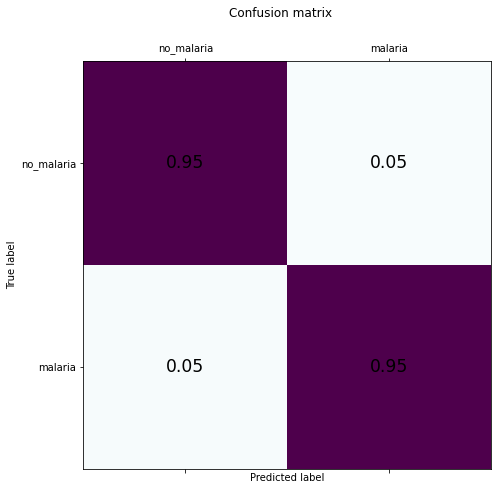

The accuracy is: 95.2%
The true positive rate is: 94.9%


In [47]:
prediction = model.predict(test_tensor)
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.flatten(), y_pred=rounded_prediction)
keras_name = 'malaria'
tpr = visualize_confusion(conf_matrix,keras_name)

print('The accuracy is: ' +'{:.1%}'.format(eval_results[2]))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))



#### Results

The true positive rate (recall) and the true negative rate are around 95%.
That's great and shows the model training was successful.

#### Visualization

For visualization the [shap](https://github.com/slundberg/shap) package is used.


In [48]:
e = shap.GradientExplainer(model,train_tensor)

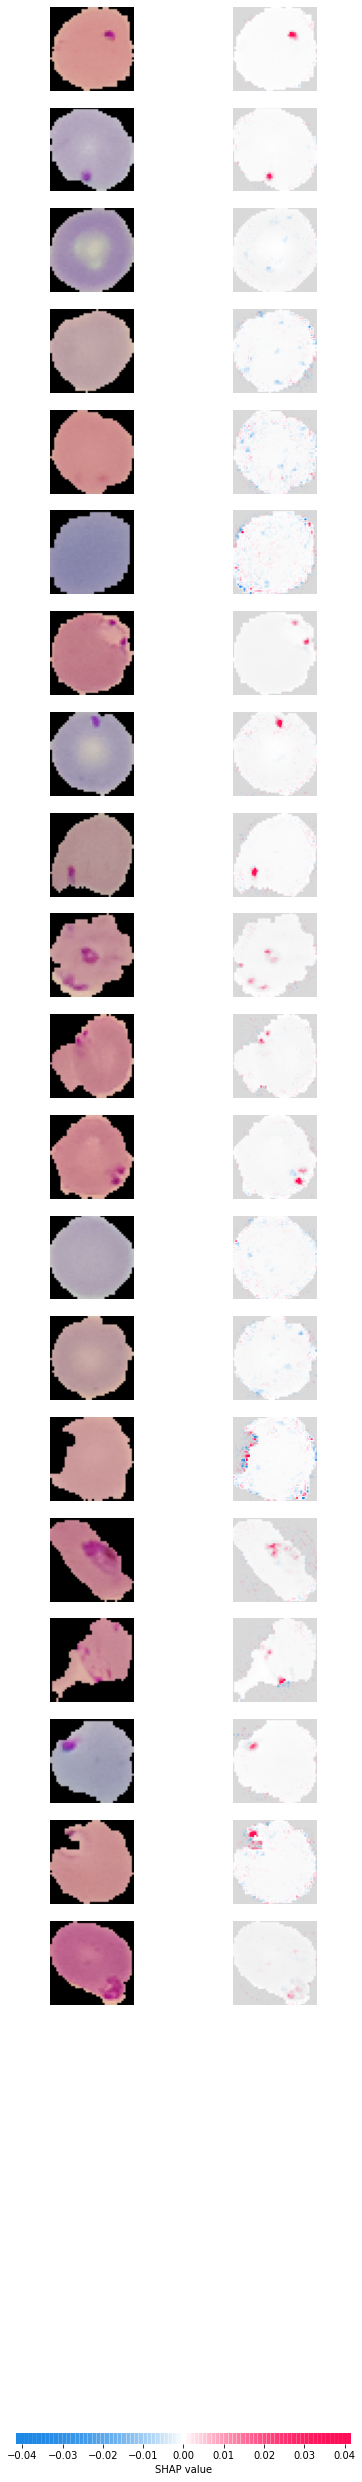

In [49]:
shap_values = e.shap_values(test_tensor[:20])

shap.image_plot(shap_values,test_tensor[:20])

The visualization shows the original image (left side) and the image with relevant features (right side).
Red "dots" are features in the picture that influence the output positively (to be parasitized) and the blue
"dots" negatively (to be uninfected).

It's clear to see that cells with dark spots are predicted as parasitized and this dots are "red" features.

#### Deeper Analysis

For later analysis it's interesting to know which images were incorrectly predicted.
For this the incorrect predicted images are separated in "not predicted (pred = 0) as parasitized but is parasitized (y_true =1)"
(_parasitized__wrong_) and "predicted (pred =1) as parasitized but is uninfected (y_true = 0)"(_uninfected__wrong_).
It is interesting to analyse which features influenced the result in such a way that it became wrong.

In [50]:
#find indices with wrong prediction
parasitized_wrong = [] #y_true = 1; pred = 0
uninfected_wrong = [] #y_true = 0; pred = 1

parasitized = []
uninfected = []

y_test_flatten = y_test.flatten()

for i in range(len(rounded_prediction[:100])):

    tmp_pred = rounded_prediction[i].numpy()
    prediction_for_test = int(tmp_pred)
    y_test_for_test = y_test_flatten[i]
    if 0 == y_test_for_test:
        if y_test_for_test != prediction_for_test:
            uninfected_wrong.append(i)
        else:
            uninfected.append(i)
    elif 1 == y_test_for_test:
        if y_test_for_test != prediction_for_test:
            parasitized_wrong.append(i)
        else:
            parasitized.append(i)


print(parasitized_wrong)
print(uninfected_wrong)

[27, 85]
[42, 84]


#### Not predicted as parasitized but is parasitized

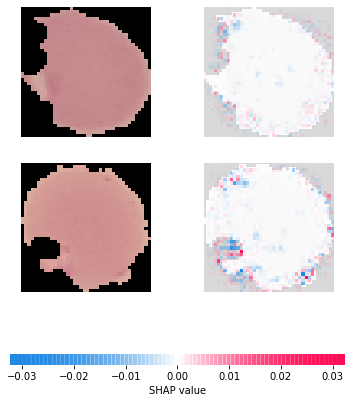

In [51]:
shap_values = e.shap_values(test_tensor[parasitized_wrong])

shap.image_plot(shap_values,test_tensor[parasitized_wrong])

There are no (big) dark spots in the cell. As visible above the spots are very significant for a parasitized cell.
In this two cases it's understandable why the model predicts this images as uninfected.


#### Predicted as parasitized but is uninfected

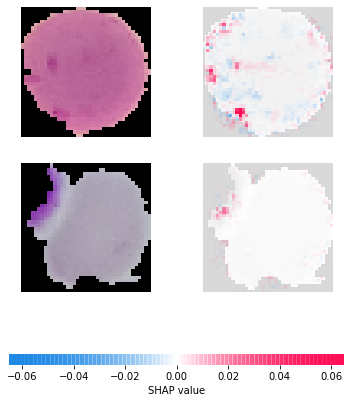

In [52]:
shap_values = e.shap_values(test_tensor[uninfected_wrong])

shap.image_plot(shap_values,test_tensor[uninfected_wrong])


There are dark spots in the cell. As visible above the spots are very significant for a parasitized cell.
In this two cases it's understandable why the model predicts this images as parasitized.